### Compare CONUS2 and USGS streamflow ###
DTT, 10/22

This notebook reads in CSVs of CONUS2 daily mean flow [cms] and daily mean USGS flow [cms] and computes comparison statistics. Gages are matched between the two csv's to make sure that we're comparing viable gage locations. 

Inputs:
- CONUS2 daily mean flow csv in [cms] - the output of `Make_CONUS2_streamflow_csv.py`
- USGS daily mean flow csv in [cms] - the output of `point_obs_CONUS2_Streamflow.ipynb`
- USGS gage metadata csv - the output of `point_obs_CONUS2_Streamflow.ipynb`

Outputs:
- Gage summary CSV of statistics  
(bias, relative bias, correlation, Spearman rank, RMSE, NSE, scaled RMSE)
for CONUS 1.0 simulated streamflow, compared to USGS observations.

In [101]:
import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
import hydroeval as he
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from scipy import stats

import matplotlib.pyplot as plt

In [2]:
water_year = 2003
# Directory containing output csv's from `Make_CONUS2_streamflow_csv.py`
organized_dir = '/glade/p/univ/ucsm0002/CONUS2/Validation/Streamflow/Organized_Daily_Flow'
# Where you want to save plots, etc. to
plot_dir = '/glade/p/univ/ucsm0002/CONUS2/Validation/Streamflow/Figures'

### Compare CONUS2 to USGS

In [13]:
### read in CONUS2 daily flow matched csv
pfdata = pd.read_csv(f'{organized_dir}/CONUS2_daily_FlowMatch_cms_2003.csv',index_col=['site_id'])
pfdata.head()

,USGS_lat,USGS_lon,x_new_adj,y_new_adj,day 001,day 002,day 003,day 004,day 005,day 006,...,day 022,day 023,day 024,day 025,day 026,day 027,day 028,day 029,day 030,day 031
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,47.069611,-69.079544,4210,2783,4.339120,3.903565,3.598231,3.739801,3.472192,2.964904,...,8.415931,9.427277,9.732380,19.499970,22.328073,21.454524,17.873519,15.879472,14.244763,12.567175
1013500,47.237394,-68.582642,4237,2810,2.607411,2.592114,2.714427,2.122667,2.426324,1.780095,...,10.531182,10.841114,10.288957,10.600749,12.061306,16.507953,16.798331,14.819481,13.234019,11.639035
1015800,46.523003,-68.371764,4276,2747,3.538157,3.513982,3.389648,3.025167,2.979538,2.794375,...,23.623506,33.084342,38.403587,35.184230,30.383635,27.200526,22.780802,20.339741,18.833875,17.107330
1017000,46.777294,-68.157194,4281,2773,8.474701,8.578840,8.433320,8.120163,7.786723,7.233890,...,17.952113,33.277058,46.507889,49.141900,53.410219,58.835318,57.151723,53.937779,50.008866,44.393264
1017550,46.628056,-67.953056,4300,2762,0.000110,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.126239,0.077560,0.050756,0.034315,0.048476,0.110372,0.062056,0.042434,0.028833,0.021246


In [14]:
# drop metadata columns, will use them later to make final csv with stats
pf_flow_matched = pfdata.drop(columns=['USGS_lat', 'USGS_lon', 'x_new_adj', 'y_new_adj'])
pf_flow_matched.head()

,day 001,day 002,day 003,day 004,day 005,day 006,day 007,day 008,day 009,day 010,...,day 022,day 023,day 024,day 025,day 026,day 027,day 028,day 029,day 030,day 031
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,4.339120,3.903565,3.598231,3.739801,3.472192,2.964904,2.711756,2.519148,2.262331,2.004412,...,8.415931,9.427277,9.732380,19.499970,22.328073,21.454524,17.873519,15.879472,14.244763,12.567175
1013500,2.607411,2.592114,2.714427,2.122667,2.426324,1.780095,1.482548,1.307613,1.202425,1.285236,...,10.531182,10.841114,10.288957,10.600749,12.061306,16.507953,16.798331,14.819481,13.234019,11.639035
1015800,3.538157,3.513982,3.389648,3.025167,2.979538,2.794375,2.514015,2.242985,2.058773,2.187055,...,23.623506,33.084342,38.403587,35.184230,30.383635,27.200526,22.780802,20.339741,18.833875,17.107330
1017000,8.474701,8.578840,8.433320,8.120163,7.786723,7.233890,6.638142,6.070441,5.608575,5.285559,...,17.952113,33.277058,46.507889,49.141900,53.410219,58.835318,57.151723,53.937779,50.008866,44.393264
1017550,0.000110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.126239,0.077560,0.050756,0.034315,0.048476,0.110372,0.062056,0.042434,0.028833,0.021246


In [15]:
### read in USGS daily flow matched csv
usgs_flow_matched = pd.read_csv(f'{organized_dir}/USGS_daily_FlowMatch_cms_2003.csv',index_col=['site_id']) 
usgs_flow_matched.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2002-10-22,2002-10-23,2002-10-24,2002-10-25,2002-10-26,2002-10-27,2002-10-28,2002-10-29,2002-10-30,2002-10-31
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,7.414600,7.386300,6.990100,6.565600,6.36750,6.19770,5.744900,5.065700,4.528000,4.414800,...,9.310700,8.57490,8.546600,8.631500,9.820100,12.508600,15.508400,16.52720,15.791400,14.319800
1013500,3.509200,3.424300,3.169600,3.113000,3.33940,2.85830,2.858300,2.631900,2.405500,2.504550,...,5.263800,5.40530,5.660000,5.914700,6.197700,6.990100,7.556100,7.30140,7.188200,7.273100
1015800,6.707100,6.226000,5.716600,5.377000,5.15060,5.03740,4.754400,4.499700,4.160100,4.188400,...,22.300400,19.07420,16.725300,14.914100,13.725500,12.904800,12.848200,13.72550,13.725500,13.074600
1017000,9.876700,9.367300,8.461700,7.952300,7.81080,7.13160,7.046700,6.678800,6.282600,6.282600,...,38.205000,33.39400,28.583000,24.507800,21.762700,20.376000,20.715600,21.79100,21.734400,20.347700
1017550,0.023772,0.024338,0.020659,0.018395,0.01981,0.01981,0.018678,0.018678,0.018961,0.021791,...,0.044997,0.03679,0.036224,0.035092,0.030847,0.041884,0.051789,0.03962,0.031979,0.027451


In [16]:
### read in USGS streamflow gage metadata for all gages with flow in October AND NWM csv for adjusted lat/long
#NWM_gage_csv = pd.read_csv('/glade/p/univ/ucsm0002/CONUS2/domain_files/NWM_Gage_Adjustments_final.csv')
usgs_gage_metadata = pd.read_csv(f'{organized_dir}/USGS_WY2003_oct_metadata.csv',index_col=['site_id'])
usgs_gage_metadata = usgs_gage_metadata.drop(columns=['Unnamed: 0'])
list(usgs_gage_metadata.columns)

['site_type',
 'agency',
 'site_name',
 'site_id_agency',
 'site_query_url',
 'site_query_access_date',
 'latitude',
 'longitude',
 'state',
 'huc',
 'tz_cd',
 'observation_id',
 'site_id:1',
 'var_id',
 'start_date_listed',
 'end_date_listed',
 'is_current',
 'is_series',
 'first_date_data_available',
 'last_date_data_available',
 'record_count',
 'date_verified_through',
 'latest_download_date',
 'file_path',
 'conus1_x',
 'conus1_y',
 'conus1_latitude',
 'conus1_longitude',
 'conus1_moved',
 'conus1_parflow_drainage_area',
 'conus2_x',
 'conus2_y',
 'conus2_latitude',
 'conus2_longitude',
 'conus2_moved',
 'conus2_parflow_drainage_area',
 'gages_drainage_sqkm',
 'bound_source',
 'class',
 'aggecoregion',
 'hydro_disturb_indx',
 'wr_report_remarks',
 'adr_citation',
 'screening_comments',
 'basin_compactness',
 'basin_elevation_mean_meters',
 'basin_elevation_max_meters',
 'basin_elevation_min_meters',
 'basin_elevation_median_meters',
 'basin_elevation_std_meters',
 'site_elevation_

### Calculate statistics

In [17]:
np.sum(pf_flow_matched.iloc[1])
#pf_flow_matched.iloc[1]

194.51368931395152

In [40]:
# set up DF for daily stats
stats_df = pd.DataFrame(columns = ['USGS_lat', 'USGS_lon', 'x_new_adj', 
                         'y_new_adj', 'r2', 'srho', 'mse', 'rmse', 'nse', 'bias', 'pbias', 'absbias', 'relbias']) #scaled RMSE

stats_df['USGS_lat'] = pfdata['USGS_lat']
stats_df['USGS_lon'] = pfdata['USGS_lon']
stats_df['x_new_adj'] = pfdata['x_new_adj']
stats_df['y_new_adj'] = pfdata['y_new_adj']
print(stats_df.shape)
stats_df.head()

(4418, 13)


,USGS_lat,USGS_lon,x_new_adj,y_new_adj,r2,srho,mse,rmse,nse,bias,pbias,absbias,relbias
site_id,,,,,,,,,,,,,
1011000,47.069611,-69.079544,4210,2783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013500,47.237394,-68.582642,4237,2810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1015800,46.523003,-68.371764,4276,2747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1017000,46.777294,-68.157194,4281,2773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1017550,46.628056,-67.953056,4300,2762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
# Set up array for stats
r2_daily = np.zeros(len(usgs_flow_matched.index))
srho_daily = np.zeros(len(usgs_flow_matched.index))
pval_daily = np.zeros(len(usgs_flow_matched.index))
mse_daily = np.zeros(len(usgs_flow_matched.index))
rmse_daily = np.zeros(len(usgs_flow_matched.index))
nse_daily = np.zeros(len(usgs_flow_matched.index))
pbias_daily = np.zeros(len(usgs_flow_matched.index))
absbias_daily = np.zeros(len(usgs_flow_matched.index))
relbias_daily = np.zeros(len(usgs_flow_matched.index))
r2_daily.shape

(4418,)

In [84]:
test_pbias = he.pbias(np.array(pf_flow_matched.iloc[1]), np.array(usgs_flow_matched.iloc[1]))
test_pbias
np.where(pf_flow_matched == 0)
test_srho = stats.spearmanr(usgs_flow_matched.iloc[1], pf_flow_matched.iloc[1])
test_srho.correlation

0.9648079497627615

In [90]:
for g in range(len(usgs_flow_matched.index)):
    gage = usgs_flow_matched.index[g]
    absbias_daily[g] = (abs(np.sum(pf_flow_matched.loc[gage])-np.sum(usgs_flow_matched.loc[gage])))/np.sum(usgs_flow_matched.loc[gage]) #absolute percent bias
    mse_daily[g] = mean_squared_error(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage])
    rmse_daily[g] = sqrt(mean_squared_error(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage]))
    r2_daily[g] = r2_score(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage])
    srho_daily[g], pval_daily[g] = stats.spearmanr(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage])
    #print(pf_flow_matched.loc[gage])
    # print(usgs_flow_matched.loc[gage])
    
    #import necessary libraries


#calculate RMSE
# sqrt(mean_squared_error(actual, pred)) 

/glade/work/tijerina/conda-envs/parflow-npl/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/glade/work/tijerina/conda-envs/parflow-npl/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/glade/work/tijerina/conda-envs/parflow-npl/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/glade/work/tijerina/conda-envs/parflow-npl/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/glade/work/tijeri

In [92]:
stats_df['absbias'] = absbias_daily
stats_df['mse'] = mse_daily
stats_df['rmse'] = rmse_daily
stats_df['r2'] = r2_daily
stats_df['srho'] = srho_daily

In [93]:
stats_df.head()

,USGS_lat,USGS_lon,x_new_adj,y_new_adj,r2,srho,mse,rmse,nse,bias,pbias,absbias,relbias
site_id,,,,,,,,,,,,,
1011000,47.069611,-69.079544,4210,2783,-0.331434,0.962597,17.735233,4.211322,NaN,NaN,NaN,0.118918,NaN
1013500,47.237394,-68.582642,4237,2810,-4.246291,0.964808,16.026274,4.003283,NaN,NaN,NaN,0.460783,NaN
1015800,46.523003,-68.371764,4276,2747,-0.843453,0.929595,63.624485,7.976496,NaN,NaN,NaN,0.171624,NaN
1017000,46.777294,-68.157194,4281,2773,-1.814542,0.833922,286.623200,16.929950,NaN,NaN,NaN,0.270155,NaN
1017550,46.628056,-67.953056,4300,2762,-6.795238,0.927436,0.003824,0.061836,NaN,NaN,NaN,0.537056,NaN


In [100]:
x_srho = np.arange(-1, 1, 0.01)

ValueError: x and y must be the same size

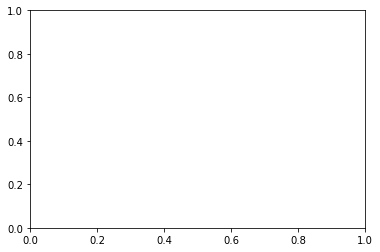

In [102]:
plt.scatter(x_srho, srho_daily)
plt.show()